In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Basics
import tensorflow as tf
import xarray as xr

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

2023-06-18 15:04:29.184805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-06-18 15:04:29.184826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<IPython.core.display.Javascript object>

### 1. Load Data

In [92]:
# Decide on lead times, to not load too much
lead_times = [1, 15, 30]
# Only raw data, because individual ensemble forecasts needed:
raw_data = ldr.load_data_raw()
# t2m data
t2m_val_data_X = []
t2m_val_data_y = []
t2m_test_data_X = []
t2m_test_data_y = []
for lead in lead_times:
    t2m_val_data_X.append(raw_data[3].predictions.isel(var=2, lead_time=lead))
    t2m_val_data_y.append(raw_data[3].ground_truth.isel(var=2, lead_time=lead))
    t2m_test_data_X.append(raw_data[4].predictions.isel(var=2, lead_time=lead))
    t2m_test_data_y.append(raw_data[4].ground_truth.isel(var=2, lead_time=lead))

# ws10 data
ws10_val_data_X = []
ws10_val_data_y = []
ws10_test_data_X = []
ws10_test_data_y = []
# First u10 and v10
for lead in lead_times:
    ws10_val_data_X.append(
        np.sqrt(
            np.add(
                np.power(raw_data[3].predictions.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[3].predictions.isel(var=1, lead_time=lead), 2)
            )
        )
    )
    ws10_val_data_y.append(
        np.sqrt(
            np.add(
                np.power(raw_data[3].ground_truth.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[3].ground_truth.isel(var=1, lead_time=lead), 2)
            )
        )
    )
    ws10_test_data_X.append(
        np.sqrt(
            np.add(
                np.power(raw_data[4].predictions.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[4].predictions.isel(var=1, lead_time=lead), 2)
            )
        )
    )
    ws10_test_data_y.append(
        np.sqrt(
            np.add(
                np.power(raw_data[4].ground_truth.isel(var=0, lead_time=lead), 2),
                np.power(raw_data[4].ground_truth.isel(var=1, lead_time=lead), 2)
            )
        )
    )


<IPython.core.display.Javascript object>

### 2. Verification Rank Hist over all gridpoints

In [102]:
def plot_rank_histogram(ensemble_forecasts, ground_truth, ax=None):
    """
    Plots a verification rank histogram for ensemble forecasts.

    The function takes as input two xarray DataArrays, one representing ensemble forecasts
    and the other representing ground truth values. It then computes the rank of each ground truth
    value within the ensemble forecasts and uses these ranks to create a histogram.

    Parameters
    ----------
    ensemble_forecasts : xarray.DataArray
        An xarray DataArray containing the ensemble forecasts. It is assumed that one of its dimensions is named 'ens'.
        The shape of this input is expected to be (number_of_forecast_days, number_of_ensemble_members, latitude, longitude).
    ground_truth : xarray.DataArray
        An xarray DataArray containing the ground truth values. The shape of this input is expected to be 
        (number_of_forecast_days, latitude, longitude).
    ax : matplotlib axes object, optional
        An axes on which to draw the histogram. If not provided, a new figure and axes object are created.

    Returns
    -------
    None
        This function doesn't return a value. It directly plots the rank histogram.

    Raises
    ------
    AssertionError
        If the inputs are not xarray DataArrays.
    """
    import matplotlib.pyplot as plt

    # Ensure the input data are xarray DataArrays
    assert isinstance(ensemble_forecasts, xr.DataArray)
    assert isinstance(ground_truth, xr.DataArray)

    # Stack the ensemble forecasts and ground truth arrays along new dimensions
    ensemble_forecasts_flat = ensemble_forecasts.stack(
        z=("forecast_date", "lat", "lon")
    )
    ground_truth_flat = ground_truth.stack(z=("forecast_date", "lat", "lon"))

    # Calculate the rank of the ground truth within the ensemble forecasts
    ranks = (ensemble_forecasts_flat < ground_truth_flat).sum("ens") + 1

    # Compute the histogram
    hist, bin_edges = np.histogram(
        ranks.values.flatten(),
        bins=np.arange(1, len(ensemble_forecasts["ens"]) + 3),
        density=False,
    )

    # Create new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the histogram
    ax.bar(bin_edges[:-1], hist, width=0.8, align="center")
    ax.set_title("Rank Histogram")
    ax.set_xlabel("Rank")
    ax.set_ylabel("Frequency")
    ax.grid(True)
    
    if ax is None:
        plt.show()


<IPython.core.display.Javascript object>

#### 2.1 t2m

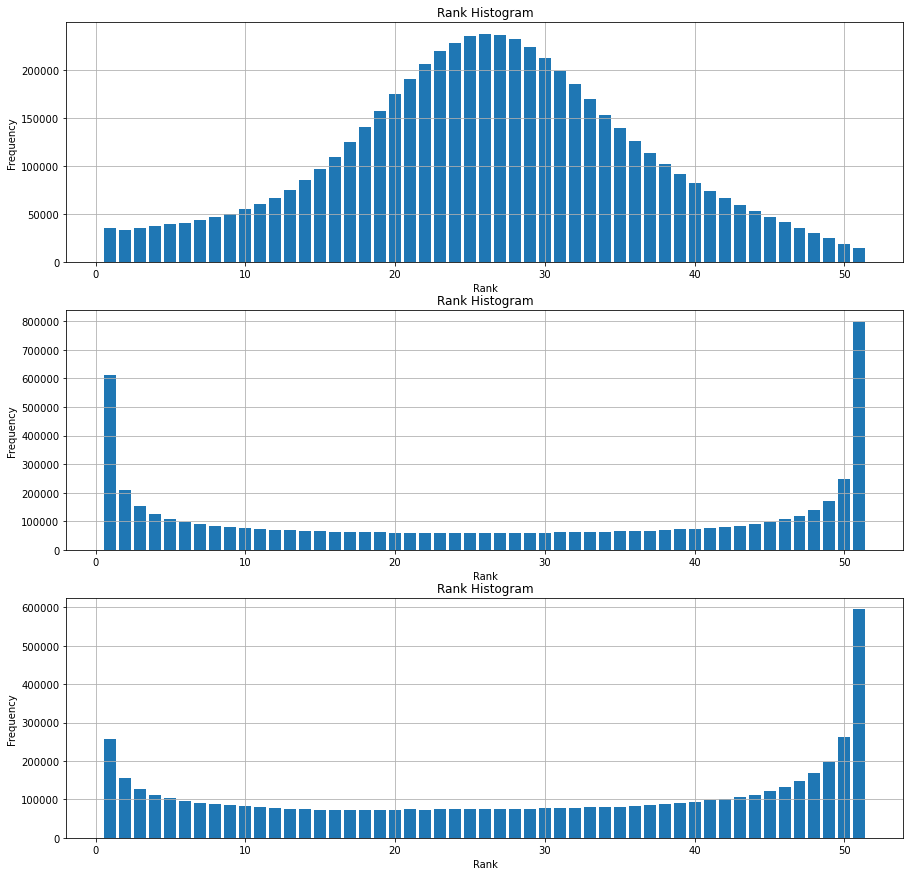

<IPython.core.display.Javascript object>

In [109]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for i in range(3):
    plot_rank_histogram(t2m_val_data_X[i], t2m_val_data_y[i], ax=axs[i])

#### 2.1 ws10

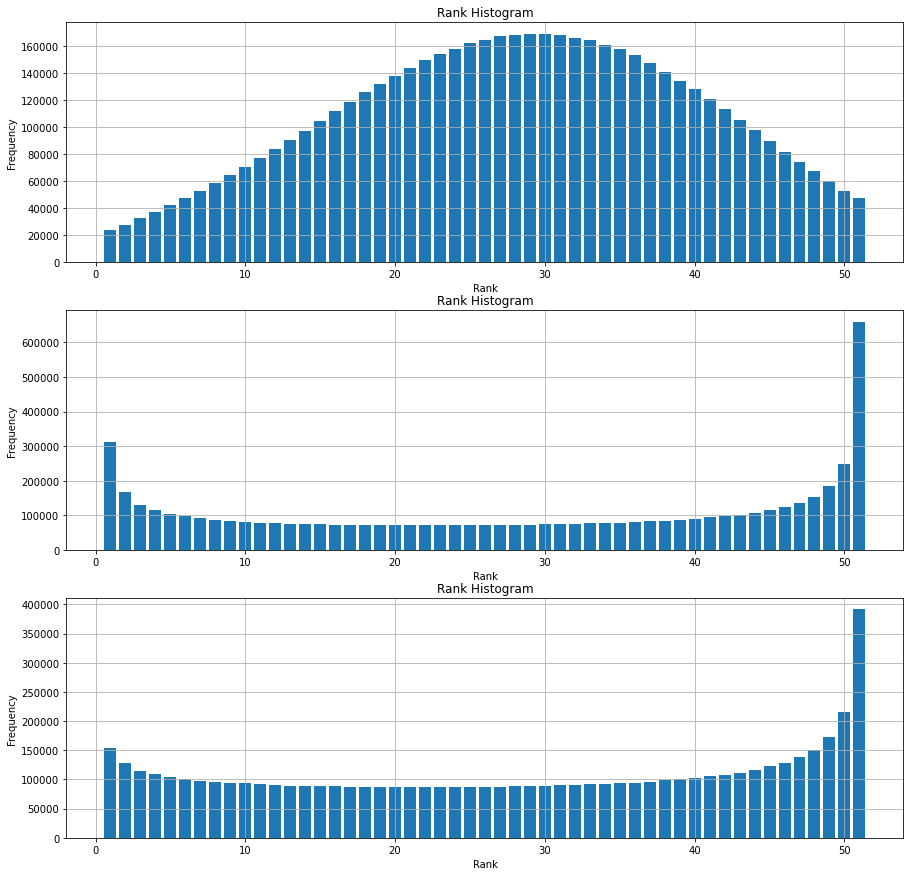

<IPython.core.display.Javascript object>

In [110]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for i in range(3):
    plot_rank_histogram(ws10_val_data_X[i], ws10_val_data_y[i], ax=axs[i])